In [813]:
import warnings

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

--------

In [814]:
df_companies = pd.read_excel('data/companies_v2.xlsx')
df_companies.head(10)

,company_id,sector,segment,industry,company_size,revenue,segment_2
0,comp_94b3dbfa3cdb,sec_none,МБ,NaN,48,111010.00,3
1,comp_1415fd049367,sec_9d8153193942,МБ,ind_10e261bd7cd8,78,107460.00,4
2,comp_b034aa428753,sec_28f0e3119b87,МБ,ind_28f0e3119b87,52,108389.00,4
3,comp_f6ad69a5a5a1,sec_9d370c38febe,МБ,ind_316195b443c6,30,111650.00,7
4,comp_c839caa6df52,sec_1a54105881cc,Крупный Public,ind_c3c0ab208b3b,2169,195718.00,6
5,comp_a0017e8bc5ea,sec_5fb21c55bb11,МБ,ind_5fb21c55bb11,166,102187.00,7
6,comp_a6572bb2d533,sec_1bc3700e30b8,Малый и средний Public,ind_11d103ed33f7,200,109751.00,4
7,comp_925b85138d0c,sec_9d8153193942,МБ,ind_135b1d02b8a4,99,109278.00,4
8,comp_4183fd8f65b5,sec_9d8153193942,КБ,ind_135b1d02b8a4,252,111957.00,7
9,comp_f0c6330dc2dd,sec_9d370c38febe,Corporate,ind_316195b443c6,нет данных,735073.00,6


company_id — уникальный ID клиента;

sector —закодированный отраслевой сектор;

segment — сегмент компании;

industry — закодированная индустрия;

company_size — число сотрудников;

revenue — нормированная годовая выручка компании за 23 год;

segment_2 — подсегмент компании;

Проведем первичное статистическое исследование исследование количественных и категориальных признаков.

Посмотрим на общую статистику числовых данных (количество, среднее значение, среднеквадратичное отклонение, минимальное и максимальное значения и тд.)

In [815]:
df_companies['company_size'] = pd.to_numeric(df_companies['company_size'], errors='coerce')
df_companies.describe()

,company_size,revenue,segment_2
count,2923.00,3007.00,3099.00
mean,574.26,163926.20,4.00
std,1342.45,410165.94,1.47
min,0.00,100066.00,0.00
25%,44.00,105257.00,3.00
50%,100.00,108955.00,4.00
75%,314.00,117063.00,4.00
max,14847.00,10297650.00,7.00


In [816]:
df_companies[['sector','segment','industry']] = df_companies[['sector','segment','industry']].fillna('Unknown') # Избавляемся от пропусков 
df_companies.describe(include=['O'])

,company_id,sector,segment,industry
count,3099,3099,3099,3099
unique,3099,10,10,34
top,comp_94b3dbfa3cdb,sec_9d370c38febe,МБ,ind_135b1d02b8a4
freq,1,704,920,600


In [817]:
df_companies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3099 entries, 0 to 3098
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   company_id    3099 non-null   object 
 1   sector        3099 non-null   object 
 2   segment       3099 non-null   object 
 3   industry      3099 non-null   object 
 4   company_size  2923 non-null   float64
 5   revenue       3007 non-null   float64
 6   segment_2     3099 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 169.6+ KB


In [818]:
df_companies.isnull().sum()

company_id        0
sector            0
segment           0
industry          0
company_size    176
revenue          92
segment_2         0
dtype: int64

In [819]:
df_companies.duplicated().sum()

np.int64(0)

------------------------    

Анализ выбросов:


<Axes: xlabel='revenue'>

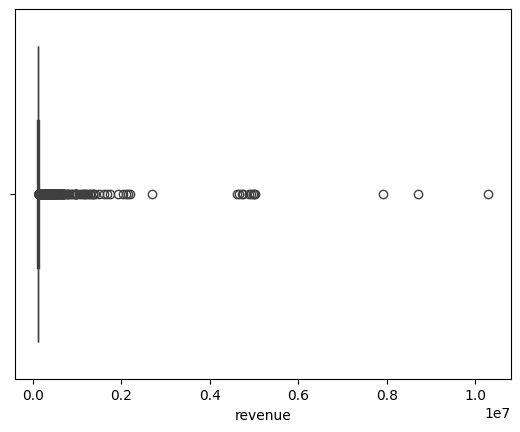

In [820]:
sns.boxplot(x=df_companies['revenue']) # посмотреть что за три правых значения / считать ли это за выброс ? 

<Axes: xlabel='company_size'>

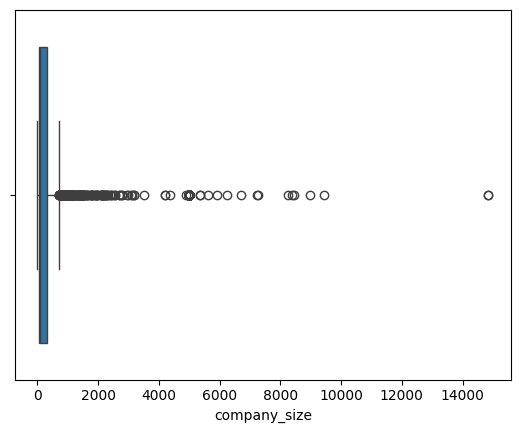

In [821]:
sns.boxplot(x=df_companies['company_size'])

<Axes: xlabel='segment_2'>

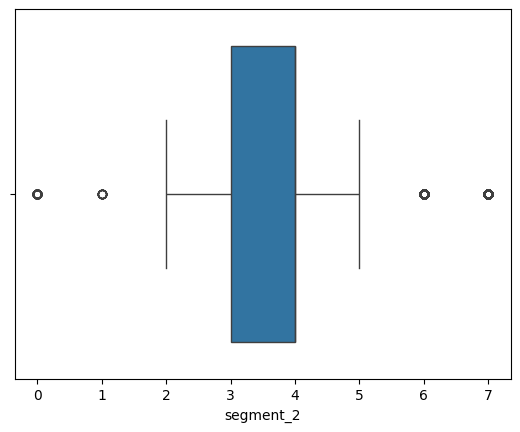

In [822]:
sns.boxplot(x=df_companies['segment_2'])

"Отклоняющиеся" значения по полям revenue, company_size не являются выбросами, и данные логически корректны. Поле segment_2 просто имеет малое число значений 0,1,6 и 7 - что тоже не является выбросом. 

Данные не нуждаются в чистке от выбросов.

In [823]:
# NOTES: оставил для возможных разборов
# Код удаления выбросов

# for column in df_companies.columns:
#     if(df_companies[column].dtype in [float, int]):
        
#         q1 = df_companies[column].quantile(0.25)
#         q3 = df_companies[column].quantile(0.75)
#         iqr = q3 - q1
#         a = q1 - 1.2 * iqr
#         b = q3 + 1.3 * iqr
#         mask = (df_companies[column] >= a) & (df_companies[column] <= b)
#         df_companies = df_companies[mask]

# df_companies.info()

<Axes: >

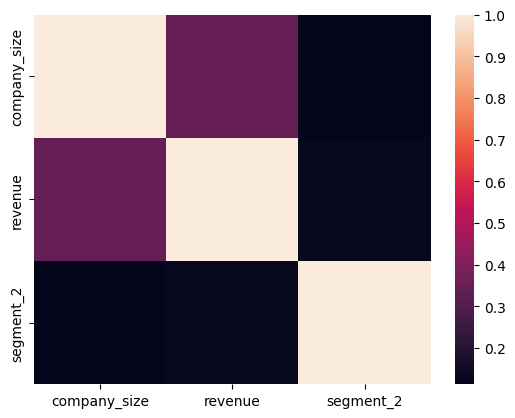

In [824]:
numeric_cols = df_companies.select_dtypes(include=['float', 'int']).columns
df_numeric = df_companies[numeric_cols]


sns.heatmap(df_numeric.corr())

Присутствует связь размера компании и дохдности на очищенных от выбросов данных ( ~ 0.6)
При не удаленных "выбросах" связь еще меньше ( ~ 0.4)

Вывод анализа: дублей нет, сильных корреляций тоже 

----

In [825]:
df_revenue = pd.read_excel('data/revenue_v2.xlsx')
df_revenue.head(10)

,row_id,company_id,sale_id,order_date,product_name,product_sum,kind_of_sale,product_duration
0,row_f40c971d4bac,comp_94b3dbfa3cdb,sal_34760cef17e9,2021-10-26,Расширения,10000,Продление,1.00
1,row_c05fdb605f5a,comp_94b3dbfa3cdb,sal_34760cef17e9,2021-10-26,Тарифы Webinar СМБ,11000,Продление,1.00
2,row_e44467c20a35,comp_94b3dbfa3cdb,sal_de1df99496b2,2022-04-27,Тарифы Webinar СМБ,11000,Продление,1.00
3,row_097e847fff08,comp_94b3dbfa3cdb,sal_de1df99496b2,2022-04-27,Расширения,10000,Продление,1.00
4,row_64222aceadd9,comp_94b3dbfa3cdb,sal_fbb04b9291d4,2021-11-27,Расширения,10000,Продление,1.00
5,row_551b3b2a58af,comp_94b3dbfa3cdb,sal_fbb04b9291d4,2021-11-27,Тарифы Webinar СМБ,11000,Продление,1.00
6,row_f9503dedbc6c,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Расширения,10000,Новая,1.00
7,row_38f3adfc0033,comp_94b3dbfa3cdb,sal_117719067179,2021-02-09,Тарифы Webinar СМБ,11000,Новая,1.00
8,row_54cd22f389bb,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Тарифы Webinar СМБ,11000,Продление,1.00
9,row_2b71eff6c5d1,comp_94b3dbfa3cdb,sal_8f5df72ac2f7,2023-03-17,Расширения,10000,Продление,1.00


row_id — ID строки;

company_id — идентификатор клиента;

sale_id — идентификатор заказа;

product_name — купленный продук;

product_sum — стоимость лицензии продукта в заказе;

sale_type — тип покупки;

product_duration — срок действия купленной лицензии;

In [826]:
df_revenue.describe()

,order_date,product_sum,product_duration
count,27119,27119.00,27119.00
mean,2020-06-22 13:40:42.169696512,14054.87,7.16
min,2014-01-22 00:00:00,10000.00,1.00
25%,2018-10-25 12:00:00,10000.00,1.00
50%,2020-11-07 00:00:00,11000.00,6.00
75%,2022-06-01 00:00:00,13000.00,12.00
max,2026-05-30 00:00:00,1000000.00,60.00
std,NaN,16895.41,6.55


In [827]:
df_revenue.describe(include=['O'])

,row_id,company_id,sale_id,product_name,kind_of_sale
count,27119,27119,27119,27119,22785
unique,27119,3099,18508,29,4
top,row_f40c971d4bac,comp_536846124f78,sal_81e21077be2b,Тарифы Webinar СМБ,Продление
freq,1,216,44,10449,13958


In [828]:
print(df_revenue['kind_of_sale'].unique())

['Продление' 'Новая' 'Возврат' 'Расширение' nan]


In [829]:
df_revenue.info()
df_revenue.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27119 entries, 0 to 27118
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   row_id            27119 non-null  object        
 1   company_id        27119 non-null  object        
 2   sale_id           27119 non-null  object        
 3   order_date        27119 non-null  datetime64[ns]
 4   product_name      27119 non-null  object        
 5   product_sum       27119 non-null  int64         
 6   kind_of_sale      22785 non-null  object        
 7   product_duration  27119 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.7+ MB


row_id                 0
company_id             0
sale_id                0
order_date             0
product_name           0
product_sum            0
kind_of_sale        4334
product_duration       0
dtype: int64

In [830]:
df_companies.duplicated().sum()

np.int64(0)

In [831]:
df_revenue[['kind_of_sale']] = df_revenue[['kind_of_sale']].fillna('Unknown') # заполнение NaN
df_revenue.isnull().sum()

row_id              0
company_id          0
sale_id             0
order_date          0
product_name        0
product_sum         0
kind_of_sale        0
product_duration    0
dtype: int64

----

Анализ выбросов

<Axes: xlabel='product_sum'>

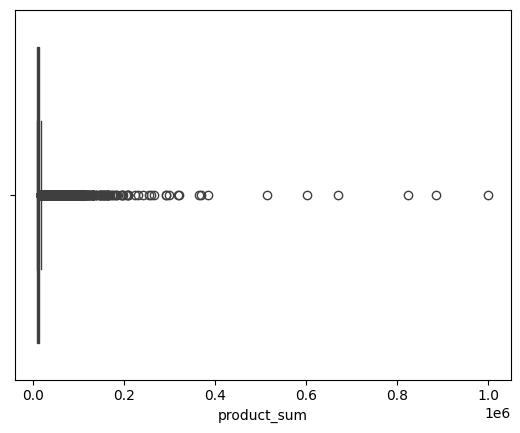

In [832]:
sns.boxplot(x=df_revenue['product_sum'])

<Axes: xlabel='product_duration'>

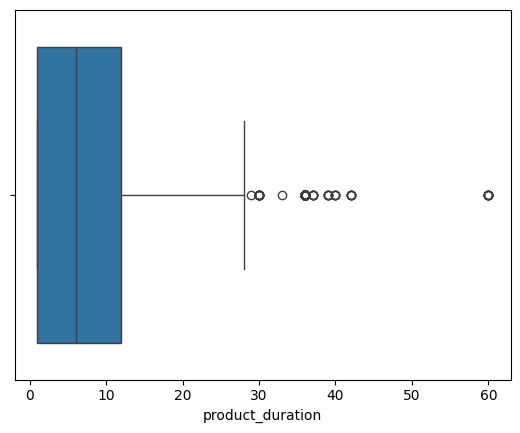

In [833]:
sns.boxplot(x=df_revenue['product_duration'])

Точечные покупки с высокой стоимостью и на длительный срок не являются выбросами данных. 

Данные не нуждаются в чистке от выбросов.


---


## Создание LTV


Бизнес задача: Найти оптимальные пути роста LTV для В2В клиентов через подобранное предложение продуктов

Суть:

- Нужно определить группы (сегменты) клиентов по LTV. Эти сегменты не являются повторением segment из таблицы компаний, который описывают тип и объем бизнеса. Здесь мы определяем разделяем клиентов по степени их пользы (т.е. денежной выгоды). Группировка клиентов по их ценности и поведенческому профилю

    Пример как можно разбить (необ. разбор & редактирование): 


    | Сегмент           | Характеристика                                   |
    | ----------------- | ------------------------------------------------ |
    | High LTV          | Большой чек, длинные лицензии, повторные покупки |
    | Growing           | Средний чек, потенциал роста                     |
    | Low LTV           | Разовые покупки                                  |
    | Enterprise Heavy  | Покупают дорогие enterprise-продукты             |
    | Short-term buyers | Берут лицензии на 1-3 месяца                     |

 
- На основании датасетов построить модель, по которой можно будет понять какой продукт предложить клиенту. 

    NBO (next best offer) - находим продукт который можно предложить конкретному выбранному клиенту.
    Look-alike - определяем сегменты, и находим клиентов близких к более высоким сегментам, и предлагаем им товары их товары

    Если некоторый клиент покукает товар X, то при предложении ему товара Y мы ожидаем прирост LTV. Задача - понять какой именно товар предлагать, и уметь доказать пользу, т.е. прирост LTV 

    План док-ва: 
    1. Берем клиентов, купивших продукт Y
    2. Считаем их LTV до покупки
    3. Считаем LTV после покупки
    4. Сравниваем с похожими клиентами без покупки


    Построить | segment | avg_LTV | median_LTV | top_products |


Вопросы насущные, которые могут помочь для составления LTV:
- Отличаются ли LTV между сегментами
- Какой сегмент даёт самый высокий LTV 
- Какие продукты покупают high-LTV клиенты
- Есть ли продукты, после которых средний чек растёт 
- Какие продукты чаще всего идут перед скачком LTV 

Для удобства можно сначала обработать revenue, и после объединять с companies 


df - главный датафрейм проекта

df_ltv можно спокойно менять, для поиска большей информации


In [834]:
df_ltv = (
    df_revenue
    .groupby('company_id')
    .agg(
        total_revenue=('product_sum','sum'),
        num_orders=('sale_id','nunique'),
        avg_check=('product_sum','mean'),
        total_duration=('product_duration','sum'),
        unique_products=('product_name','nunique'),
        first_purchase=('order_date','min'),
        last_purchase=('order_date','max')
    )
    .reset_index()
)

df_ltv['customer_lifetime_days'] = (
    df_ltv['last_purchase'] - df_ltv['first_purchase']
).dt.days

df = df_ltv.merge(df_companies, on='company_id', how='left')

In [835]:
df.head()

,company_id,total_revenue,num_orders,avg_check,total_duration,unique_products,first_purchase,last_purchase,customer_lifetime_days,sector,segment,industry,company_size,revenue,segment_2
0,comp_0000de60334c,60000,6,10000.00,6.00,1,2022-09-24,2023-06-25,274,sec_e61177ed3f58,СБ,ind_17fc30c258ad,1000.00,153309.00,6
1,comp_0004b685d8d6,16000,1,16000.00,12.00,1,2019-05-03,2019-05-03,0,Unknown,Corporate,ind_5fb21c55bb11,100.00,141608.00,3
2,comp_001eac7794df,290000,28,10000.00,51.00,2,2020-09-23,2023-10-03,1105,sec_07f5ebaa60c6,Малый и средний Public,ind_d2091f85a3a3,100.00,109670.00,4
3,comp_002f5166d79b,31000,1,10333.33,3.00,2,2020-11-28,2020-11-28,0,sec_07f5ebaa60c6,Unknown,ind_d2091f85a3a3,200.00,109292.00,0
4,comp_00323bea932a,15000,1,15000.00,12.00,1,2020-08-17,2020-08-17,0,sec_9d370c38febe,КБ,ind_316195b443c6,139.00,115737.00,3


----

### Сегментирование на основании длительности, кол-ва и общего дохода

In [836]:
df['recency'] = (df['last_purchase'].max() - df['last_purchase']).dt.days

# Логарифмируем total_revenue для снижения skew и устранения overflow при масштабировании
df['log_revenue'] = np.log1p(df['total_revenue'])

features = ['recency', 'num_orders', 'log_revenue', "avg_check"]
X = df[features].copy()
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Валидация и оптимизация сегментации

Проверяем качество кластеризации: метод локтя, silhouette, баланс кластеров. Подбираем оптимальное число сегментов.

  Calinski-Harabasz (↑ лучше): 1554
  Davies-Bouldin (↓ лучше): 0.699


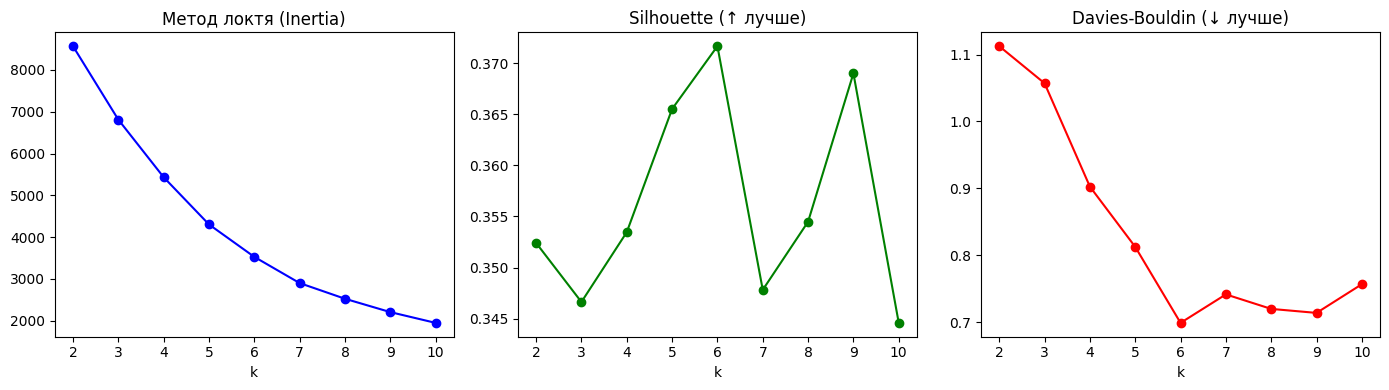

In [837]:
# Валидация: подбор оптимального k (2..10)
k_range = range(2, 11)
inertias, silhouettes, calinski, davies = [], [], [], []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))
    calinski.append(calinski_harabasz_score(X_scaled, labels))
    davies.append(davies_bouldin_score(X_scaled, labels))

print(f'  Calinski-Harabasz (↑ лучше): {calinski[np.argmax(silhouettes)]:.0f}')
print(f'  Davies-Bouldin (↓ лучше): {davies[np.argmax(silhouettes)]:.3f}')

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
axes[0].plot(k_range, inertias, 'bo-'); axes[0].set_title('Метод локтя (Inertia)'); axes[0].set_xlabel('k')
axes[1].plot(k_range, silhouettes, 'go-'); axes[1].set_title('Silhouette (↑ лучше)'); axes[1].set_xlabel('k')
axes[2].plot(k_range, davies, 'ro-'); axes[2].set_title('Davies-Bouldin (↓ лучше)'); axes[2].set_xlabel('k')
plt.tight_layout(); plt.show()

In [838]:
optimal_k = 4

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X_scaled)

In [839]:
# Проверка баланса кластеров и итоговые метрики
cluster_stats = df.groupby('cluster').agg(
    count=('company_id', 'count'),
    avg_total_revenue=('total_revenue', 'mean'),
    avg_recency=('recency', 'mean'),
    avg_num_orders=('num_orders', 'mean'),
    avg_check=('avg_check', 'mean')
).round(0)
cluster_stats['share_%'] = (cluster_stats['count'] / len(df) * 100).round(1)
print('Баланс сегментов (оптимизированная кластеризация):')
print(cluster_stats)
print(f'\nSilhouette score: {silhouette_score(X_scaled, df["cluster"]):.3f}')

Баланс сегментов (оптимизированная кластеризация):
         count  avg_total_revenue  avg_recency  avg_num_orders  avg_check  \
cluster                                                                     
0          873           29611.00      2897.00            2.00   11531.00   
1          659          366511.00      1209.00           17.00   15917.00   
2           11         1070364.00      1187.00            5.00  126547.00   
3         1556           65552.00      1343.00            4.00   12884.00   

         share_%  
cluster           
0          28.20  
1          21.30  
2           0.40  
3          50.20  

Silhouette score: 0.353


### Проверка сегментации путем построение классификатора

Проверка проверяет правильность только с математической точки зрения, не бизнеса!

In [840]:
features = ['recency', 'num_orders', 'log_revenue', 'avg_check']

X = df[features]
y = df['cluster']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [841]:
acc = accuracy_score(y_test, y_pred)

print(f"Accuracy: {acc:.3f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.975
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       258
           1       0.96      0.98      0.97       203
           2       1.00      1.00      1.00         3
           3       0.98      0.97      0.98       466

    accuracy                           0.98       930
   macro avg       0.98      0.98      0.98       930
weighted avg       0.98      0.98      0.98       930



In [842]:
importance = pd.Series(clf.feature_importances_, index=features)
print(importance.sort_values(ascending=False)) 

recency       0.45
log_revenue   0.36
num_orders    0.17
avg_check     0.03
dtype: float64
